# Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np

## Učitavanje podataka

In [91]:
drive.mount("/content/drive")
X = pd.read_csv("/content/drive/MyDrive/UZOP-PROJEKT/uzop_projekt_ulazni_podaci.csv", sep = ",")
X.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [92]:
X.shape

(373, 15)

## Početni pregled podataka

In [93]:
X.columns.values

array(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F',
       'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype=object)

Pojašnjenja značajki:
 - Subject ID - id pacijenta
 - MRI ID - id MRI skenova
 - Group - ciljani razred - oznaka je li osobi dijagnosticiran Alzheimer (Converted, Nondemented, Demented)
 - Visit - broj posjete
 - MR Delay - prošlo vrijeme u danima od prvog nalaza
 - M/F - spol pacijenta
 - Hand - dešnjak ili lijevak
 - Age - starost
 - EDUC - godine školovanja
 - SES - socioekonomski status
 - MMSE - preliminarni mentalni pregled
 - CDR - kliničko ocjenjivanje demencije
 - eTIV - procijenjeni ukupni intrakranijalni volumen
 - nWBV - normalizirani volumen mozga
 - ASF - faktor skaliranja atlasa

In [94]:
X.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


Tablica prikazuje deskriptivnu statistiku podataka s vrijedostima max, min, prosjek, medijan, ostali kvantili, ukupan broj zapisa i iznos standardne devijacije.

Ovaj skup se sastoji od longitudinalne zbirke MRI podataka (373 zapisa) od ukupno 150 pacijenata u dobi od 60 do 98 godina. Svaki pacijent je skeniran minimalno 2 puta, a maksimalno 5 puta, s tim da je od prošlog posjeta prošla barem godina dana. Svi subjekti su dešnjaci i uključuje 62 muškaraca i 88 žena. 72 ispitanika karakterizirana su kao nedementni tijekom cijele studije. 64 ispitanika bila su karakterizirana kao dementna tijekom prvog pregleda i ostali su takvi, uključujući 51 osobu s blagom do umjerenom Alzheimerovom bolešću. Posljednjih 14 ljudi bilo je u početku karakterizirano kao nedementno, da bi ih kasnije karakterizirali kao dementne tijekom kasnijih posjeta.

In [95]:
X.nunique()

Subject ID    150
MRI ID        373
Group           3
Visit           5
MR Delay      201
M/F             2
Hand            1
Age            39
EDUC           12
SES             5
MMSE           18
CDR             4
eTIV          286
nWBV          136
ASF           265
dtype: int64

Lako je zaključiti da je MRI ID monotoni atribut, a Hand konstantan atribut. Izbacimo atribute MRI ID i Hand iz skupa podataka.

In [96]:
X.drop(('MRI ID'), axis=1, inplace=True)
X.drop(('Hand'), axis=1, inplace=True)
X.head()

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


Pogledajmo koje su sve vrijednosti numeričke.

In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   Group       373 non-null    object 
 2   Visit       373 non-null    int64  
 3   MR Delay    373 non-null    int64  
 4   M/F         373 non-null    object 
 5   Age         373 non-null    int64  
 6   EDUC        373 non-null    int64  
 7   SES         354 non-null    float64
 8   MMSE        371 non-null    float64
 9   CDR         373 non-null    float64
 10  eTIV        373 non-null    int64  
 11  nWBV        373 non-null    float64
 12  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(3)
memory usage: 38.0+ KB


Sada imamo novi problem s podatcima - nedostajući podatci. Provjerimo koliko je takvih podataka.

In [98]:
X.isna().sum()

Subject ID     0
Group          0
Visit          0
MR Delay       0
M/F            0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Generalno, opcije za rješavanje problema nedostajućih vrijednosti su:

* zamijeniti srednjom vrijednošću
* u potpunosti izbaciti te zapise iz skupa podataka
* u potpunosti izbaciti te značajke iz skupa podataka
* interpolacija
* pronalazak točnih vrijednosti iz drugih izvora podataka

Mi ćemo izbaciti 2 zapisa u slučaju značajke MMSE, a ubaciti srednju vrijednost socioekonomskog statusa tamo gdje nedostaje ta informacija.

In [99]:
X = X.loc[X.MMSE.notnull(), :]
X.loc[X.SES.isna(),'SES'] = X.loc[:,'SES'].mean()
X.head()

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,87,14,2.000000,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,88,14,2.000000,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,75,12,2.460452,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,76,12,2.460452,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,Demented,3,1895,M,80,12,2.460452,22.0,0.5,1698,0.701,1.034


Provjerimo ima li u skupu podataka stršećih vrijednosti.

In [100]:
X.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,1.878706,593.876011,77.018868,14.611860,2.460452,27.342318,0.287062,1489.876011,0.729526,1.193776
std,0.923480,636.636500,7.660864,2.877737,1.107647,3.683244,0.371912,174.990473,0.037229,0.136533
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1358.500000,0.700000,1.098500
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1471.000000,0.729000,1.193000
75%,2.000000,869.500000,82.000000,16.000000,3.000000,30.000000,0.500000,1598.000000,0.756000,1.292000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


Temeljem ovog ispisa kandidati za stršeće podatke su MR Delay i MMSE. Maksimalna vrijednost MR Delay-a dosta odskače, ali nije nemoguća. Također minimalna vrijednost MMSE je jako niska. Pogledajmo dodatno te značajke.

In [101]:
print('MR Delay > 365: ', (X['MR Delay'] > 365).sum())
print('MR Delay > 730: ', (X['MR Delay'] > 730).sum())
print('MR Delay > 1095: ', (X['MR Delay'] > 1095).sum())
print('MR Delay > 1460: ', (X['MR Delay'] > 1460).sum())
print('MR Delay > 1825: ', (X['MR Delay'] > 1825).sum())
print('MR Delay > 2190: ', (X['MR Delay'] > 2190).sum())
print('MR Delay > 2555: ', (X['MR Delay'] > 2555).sum())

MR Delay > 365:  216
MR Delay > 730:  127
MR Delay > 1095:  77
MR Delay > 1460:  43
MR Delay > 1825:  19
MR Delay > 2190:  8
MR Delay > 2555:  1


In [102]:
print('MMSE < 30: ', (X.MMSE < 30).sum())
print('MMSE < 25: ', (X.MMSE < 25).sum())
print('MMSE < 20: ', (X.MMSE < 20).sum())
print('MMSE < 15: ', (X.MMSE < 15).sum())
print('MMSE < 10: ', (X.MMSE < 10).sum())
print('MMSE < 5: ', (X.MMSE < 5).sum())

MMSE < 30:  257
MMSE < 25:  57
MMSE < 20:  17
MMSE < 15:  2
MMSE < 10:  2
MMSE < 5:  1


Ova dva zapisa jako odudaraju od ostalih zapisa i mogu se smatrati stršećim vrijednostima. Za sada nećemo ništa poduzimati po tom pitanju, no te činjenice treba biti svjestan prilikom modeliranja.

In [103]:
le = LabelEncoder()
le.fit(X.loc[:,'Group'])
X.loc[:,'Group'] = le.transform(X.loc[:,'Group'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 372
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  371 non-null    object 
 1   Group       371 non-null    int64  
 2   Visit       371 non-null    int64  
 3   MR Delay    371 non-null    int64  
 4   M/F         371 non-null    object 
 5   Age         371 non-null    int64  
 6   EDUC        371 non-null    int64  
 7   SES         371 non-null    float64
 8   MMSE        371 non-null    float64
 9   CDR         371 non-null    float64
 10  eTIV        371 non-null    int64  
 11  nWBV        371 non-null    float64
 12  ASF         371 non-null    float64
dtypes: float64(5), int64(6), object(2)
memory usage: 40.6+ KB


In [104]:
def klasificiraj(df):
  X = df.loc[:, df.columns != 'Group']
  y = df.loc[:, 'Group']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  model = RandomForestClassifier(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  scores = cross_val_score(model, X, y, cv=20)

  print('Točnost: ', scores.mean(), ' +- ', scores.std())

In [105]:
X_tmp = X.loc[:,['Group', 'Visit', 'MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']]
klasificiraj(X_tmp)

Točnost:  0.9033625730994151  +-  0.046568171644455245


Točnost modela je 90.3%

In [106]:
le.fit(X.loc[:,'M/F'])
X.loc[:,'M/F'] = le.transform(X.loc[:,'M/F'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 372
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  371 non-null    object 
 1   Group       371 non-null    int64  
 2   Visit       371 non-null    int64  
 3   MR Delay    371 non-null    int64  
 4   M/F         371 non-null    int64  
 5   Age         371 non-null    int64  
 6   EDUC        371 non-null    int64  
 7   SES         371 non-null    float64
 8   MMSE        371 non-null    float64
 9   CDR         371 non-null    float64
 10  eTIV        371 non-null    int64  
 11  nWBV        371 non-null    float64
 12  ASF         371 non-null    float64
dtypes: float64(5), int64(7), object(1)
memory usage: 40.6+ KB


In [107]:
X_tmp = X.loc[:,['Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']]
klasificiraj(X_tmp)

Točnost:  0.9058479532163742  +-  0.041481325755617936


Dodavanje spola kao značajke povećalo je točnost modela s 90.3% na 90.6%.

In [126]:
X[(X['Visit'] == 1)&(X['M/F'] == 1)][['Group', 'M/F']].groupby(['Group'], as_index=False).count()

,Group,M/F
0,0,4
1,1,36
2,2,22


36 muškaraca je dementno od prvog nalaza, 22 nisu, a 4 je dijagnosticirano tijekom ispitivanja.

In [127]:
X[(X['Visit'] == 1)&(X['M/F'] == 0)][['Group', 'M/F']].groupby(['Group'], as_index=False).count()

,Group,M/F
0,0,10
1,1,28
2,2,50


28 žena je dementno od prvog nalaza, 50 nije, a 10 je dijagnosticirano tijekom ispitivanja.

In [116]:
X[X['Visit'] == 1][['M/F', 'Group']].groupby(['M/F'], as_index=False).mean()

,M/F,Group
0,0,1.454545
1,1,1.290323


Iz ove tablice možemo zaključiti da su muškarci više dementni od žena.

In [120]:
X[X['Visit'] == 1][['EDUC', 'Group']].groupby(['EDUC'], as_index=False).mean()

,EDUC,Group
0,6,1.000000
1,8,1.250000
2,11,1.600000
3,12,1.209302
4,13,1.700000
5,14,1.307692
6,15,1.428571
7,16,1.343750
8,17,1.666667
9,18,1.653846


Tablica prikazuje relaciju između duljine perioda obrazovanja s pojavom Alzheimerove bolesti. Ako je iznos neke grupe bliži jedinici to znači da je veća vjerojatnost da su ljudi u njoj dementni, dok obrnuto vrijedi za ljude iz grupe kojoj je iznos bliži broju 2.

In [109]:
X.describe()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,1.412399,1.878706,593.876011,0.431267,77.018868,14.611860,2.460452,27.342318,0.287062,1489.876011,0.729526,1.193776
std,0.665568,0.923480,636.636500,0.495922,7.660864,2.877737,1.107647,3.683244,0.371912,174.990473,0.037229,0.136533
min,0.000000,1.000000,0.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,1.000000,0.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1358.500000,0.700000,1.098500
50%,2.000000,2.000000,552.000000,0.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1471.000000,0.729000,1.193000
75%,2.000000,2.000000,869.500000,1.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1598.000000,0.756000,1.292000
max,2.000000,5.000000,2639.000000,1.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


## Vizualizacija podataka

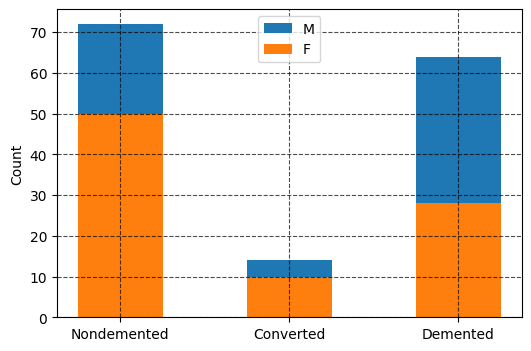

In [176]:
plt.figure(figsize=(6, 4))
plt.bar(['Nondemented', 'Converted', 'Demented'], [22, 4, 36], 0.5, label='M', bottom=[50, 10, 28])
plt.bar(['Nondemented', 'Converted', 'Demented'], [50, 10, 28], 0.5, label='F')
plt.legend(loc='best')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7, color='black')
plt.show()

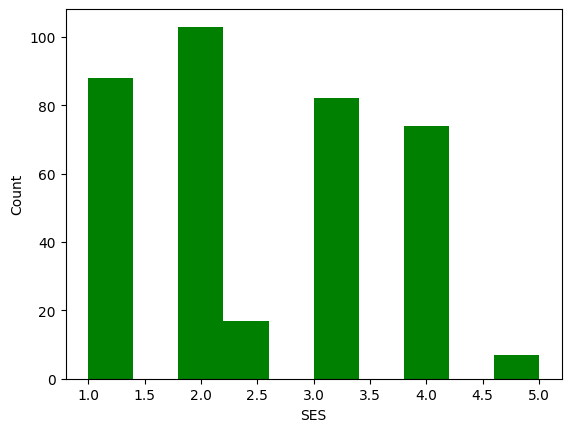

In [193]:
plt.hist(X.SES, color = 'green')
plt.xlabel('SES')
plt.ylabel('Count')
plt.show()

Prisjetimo se da smo za 17 nepostojećih zapisa značajke SES unjeli prosječnu vrijednost socioekonomskog statusa.

Zato sada imamo 6 klasa na grafu, a ne 5 kao u ulaznim podacima.

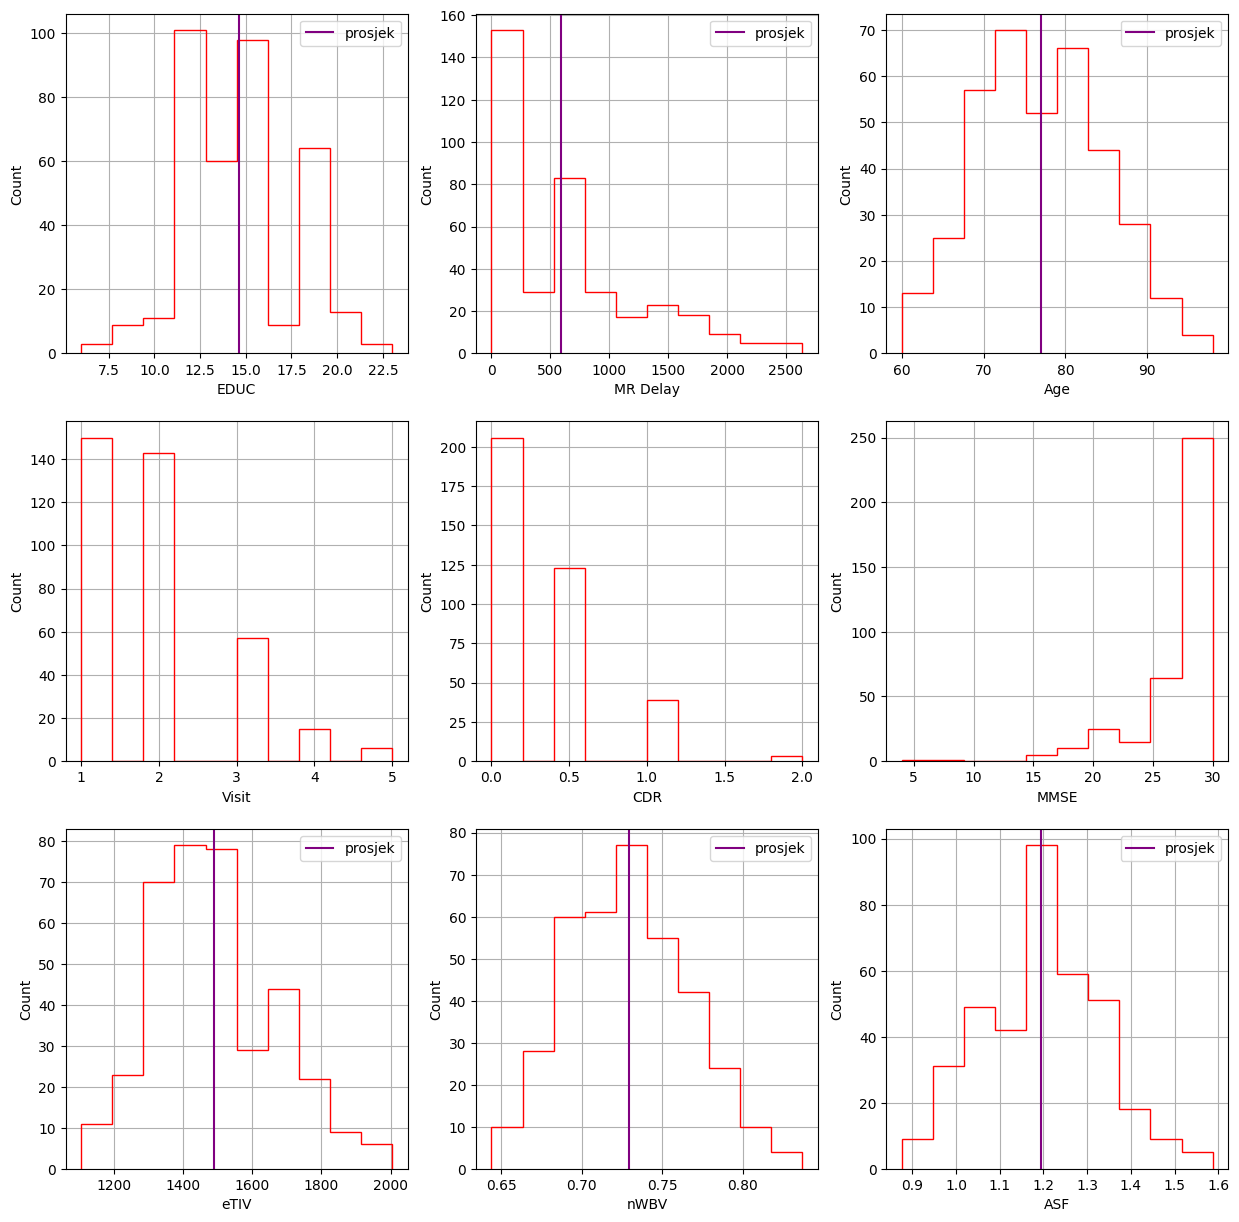

In [220]:
plt.figure(figsize=(15, 15))
plt.subplot(331)
plt.hist(X.EDUC, histtype='step', color = 'red')
plt.xlabel('EDUC')
plt.ylabel('Count')
plt.axvline(X.EDUC.mean(), color = 'purple', label = 'prosjek')
plt.legend()
plt.grid()
plt.subplot(332)
plt.hist(X['MR Delay'], histtype='step', color = 'red')
plt.xlabel('MR Delay')
plt.ylabel('Count')
plt.axvline(X['MR Delay'].mean(), color = 'purple', label = 'prosjek')
plt.legend()
plt.grid()
plt.subplot(333)
plt.hist(X.Age, histtype='step', color = 'red')
plt.xlabel('Age')
plt.ylabel('Count')
plt.axvline(X.Age.mean(), color = 'purple', label = 'prosjek')
plt.legend()
plt.grid()
plt.subplot(334)
plt.hist(X.Visit, histtype='step', color = 'red')
plt.xlabel('Visit')
plt.ylabel('Count')
plt.grid()
plt.subplot(335)
plt.hist(X.CDR, histtype='step', color = 'red')
plt.xlabel('CDR')
plt.ylabel('Count')
plt.grid()
plt.subplot(336)
plt.hist(X.MMSE, histtype='step', color = 'red')
plt.xlabel('MMSE')
plt.ylabel('Count')
plt.grid()
plt.subplot(337)
plt.hist(X.eTIV, histtype='step', color = 'red')
plt.xlabel('eTIV')
plt.ylabel('Count')
plt.axvline(X.eTIV.mean(), color = 'purple', label = 'prosjek')
plt.legend()
plt.grid()
plt.subplot(338)
plt.hist(X.nWBV, histtype='step', color = 'red')
plt.xlabel('nWBV')
plt.ylabel('Count')
plt.axvline(X.nWBV.mean(), color = 'purple', label = 'prosjek')
plt.legend()
plt.grid()
plt.subplot(339)
plt.hist(X.ASF, histtype='step', color = 'red')
plt.xlabel('ASF')
plt.ylabel('Count')
plt.axvline(X.ASF.mean(), color = 'purple', label = 'prosjek')
plt.legend()
plt.grid()
plt.show()

Za grafove u nastavku vrijedi sljedeća legenda:
*   0 = Converted
*   1 = Demented
*   2 = Nondemented

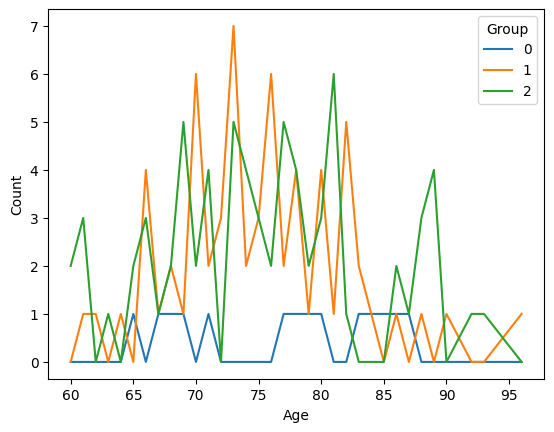

In [259]:
grouped_data_age = X[X['Visit'] == 1][['Age', 'Group']].groupby(['Age', 'Group']).size().unstack(fill_value=0)
grouped_data_age.plot(kind='line')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

Očekivali bismo da što je čovjek stariji to je više dementan, no nije tako.

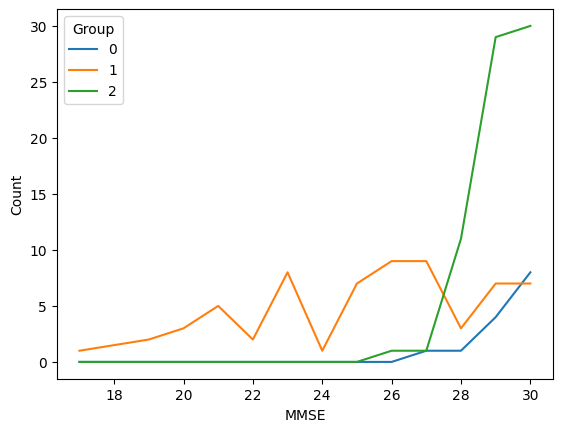

In [260]:
grouped_data_mmse = X[X['Visit'] == 1][['MMSE', 'Group']].groupby(['MMSE', 'Group']).size().unstack(fill_value=0)
grouped_data_mmse.plot(kind='line')
plt.xlabel('MMSE')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

Međutim, što je preliminarni mentalni pregled lošiji to je veća šansa za demencijom.

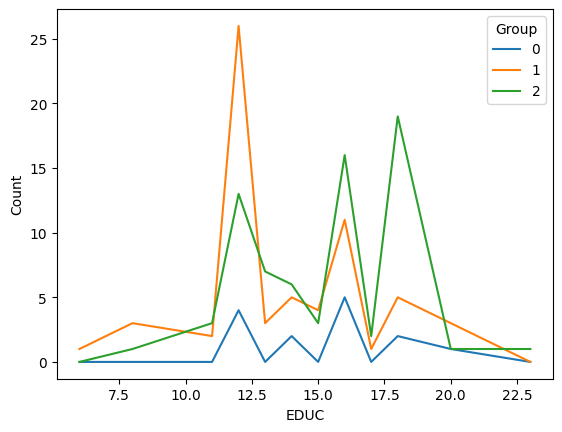

In [261]:
grouped_data_educ = X[X['Visit'] == 1][['EDUC', 'Group']].groupby(['EDUC', 'Group']).size().unstack(fill_value=0)
grouped_data_educ.plot(kind='line')
plt.xlabel('EDUC')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

Već smo izjavili ranije da čovjek ima manju šansu oboliti ako se duže obrazuje. Sada smo to i prikazali na grafu.

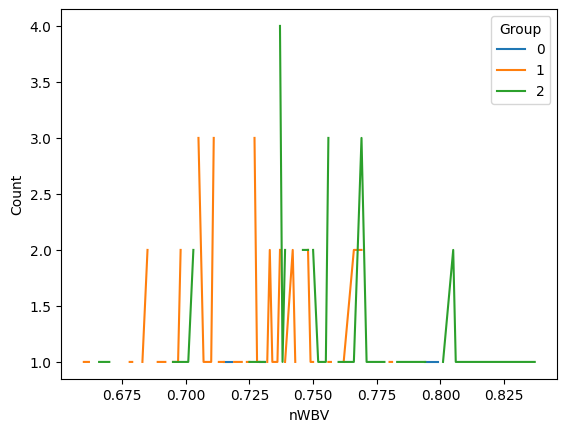

In [262]:
grouped_data_nwbv = X[X['Visit'] == 1][['nWBV', 'Group']].groupby(['nWBV', 'Group']).size().unstack()
grouped_data_nwbv.plot(kind='line')
plt.xlabel('nWBV')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

Za kraj uočavamo da će pojava Alzheimerove bolesti biti učestalija za pacijenta manjeg normaliziranog volumena mozga.